
# 🚍 NYC Bus Reliability vs Weather, Traffic, and Service Alerts

**Goal:** quantify how weather, traffic, and service disruptions relate to NYC bus **Wait Assessment (WA)**.

> _Checkpoint 2 — Exploratory Data Analysis & Visualization (IT4063C)_



## 🧭 Overview
Street-running buses are exposed to weather and surface traffic, and riders feel it when reliability slips.
This notebook pulls **three different data acquisition methods** (CSV files, JSON API, and a CSV API endpoint),
cleans and aligns them at the monthly level, runs EDA, and builds visualizations. I keep comments brief and first-person,
and I include light debugging prints so I can see what's going right (or not).



## 🗂️ Data Sources
- **MTA Bus Performance (Wait Assessment)** — `data/bus_data.csv` (CSV)
- **NOAA GHCN-Daily – Central Park (USW00094728)** — `data/weather_data.csv` (CSV)
- **NYC DOT Traffic** — JSON API: `https://data.ny.gov/resource/7kct-peq7.json`
- **MTA Alerts (Historical/Recent)** — JSON API: `https://data.ny.gov/api/v3/views/7kct-peq7/query.json`

These cover **CSV files**, **JSON API**, and **Protocol Buffers / CSV API** acquisition methods.


In [1]:

# Imports + config
import os, math, json, time, sys
from datetime import datetime, timezone
import numpy as np
import pandas as pd
import requests
from requests.adapters import HTTPAdapter, Retry
import matplotlib.pyplot as plt
import plotly.express as px

# Optional: GTFS-rt parsing (alerts)
try:
    from google.transit import gtfs_realtime_pb2
    HAVE_GTFS = True
except Exception:
    HAVE_GTFS = False

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)
print("[INFO] Notebook started. Python", sys.version.split()[0])

# Endpoints (kept separate so I can tweak easily)
TRAFFIC_URL = "https://data.cityofnewyork.us/resource/i4gi-tjb9.json"
ALERTS_CSV_URL = "https://data.ny.gov/resource/7kct-peq7.csv"
GTFS_ALERTS_URL = "https://api-endpoint.mta.info/Dataservice/mtagtfsfeeds/camsys%2Fbus-alerts"


[INFO] Notebook started. Python 3.11.9


In [3]:

# Helper functions
def pct(num, den):
    return 0 if den == 0 else 100.0 * num / den

def must_have_cols(df, cols, name):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"[FATAL] {name} missing required columns: {missing}")

def nonempty_df(df, name):
    if df is None or len(df) == 0:
        raise ValueError(f"[FATAL] {name} is empty")
    print(f"[OK] {name}: shape={df.shape}")

def to_month_start(ts):
    s = pd.to_datetime(ts, errors='coerce')
    return s.dt.to_period('M').dt.to_timestamp()

def print_range(df, col, name):
    if col not in df:
        print(f"[WARN] {name}.{col} missing")
        return
    v = df[col].dropna()
    if len(v):
        print(f"[DEBUG] {name}.{col} range: {v.min()} → {v.max()}")
    else:
        print(f"[WARN] {name}.{col} has no non-null values")

class Backoff:
    @staticmethod
    def sleep(i, base=1.2):
        t = base ** i + np.random.random() * 0.3
        time.sleep(t)
        print(f"[DEBUG] backoff ~{t:.2f}s")

def robust_session(total=5, backoff=0.8):
    r = Retry(total=total, backoff_factor=backoff, status_forcelist=[429,500,502,503,504], allowed_methods=frozenset(['GET']))
    s = requests.Session()
    s.mount('https://', HTTPAdapter(max_retries=r))
    return s


In [4]:

# === CSV 1: MTA Bus Performance ===
bus_path = 'data/bus_data.csv'
if not os.path.exists(bus_path):
    raise FileNotFoundError(f"[FATAL] Missing {bus_path}")
bus = pd.read_csv(bus_path, na_values=['', ' ', 'null', 'NULL'])
nonempty_df(bus, 'bus_raw')
bus.columns = [c.strip().lower().replace(' ', '_') for c in bus.columns]
must_have_cols(bus, ['month','wait_assessment','number_of_trips_passing_wait','number_of_scheduled_trips'], 'bus_raw')

bus['date'] = pd.to_datetime(bus['month'], errors='coerce')
bad = bus['date'].isna().sum()
print(f"[DEBUG] bus_raw bad date rows: {bad}/{len(bus)} ({pct(bad, len(bus)):.2f}%)")
bus = bus.dropna(subset=['date'])

for c in ['number_of_trips_passing_wait','number_of_scheduled_trips']:
    bus[c] = pd.to_numeric(bus[c].astype(str).str.replace(',','', regex=False), errors='coerce')
bus['wait_assessment'] = pd.to_numeric(bus['wait_assessment'].astype(str).str.rstrip('%'), errors='coerce')/100.0
print_range(bus, 'wait_assessment', 'bus_raw')

# Monthly aggregation — weighted WA
b = bus.copy()
b['date'] = to_month_start(b['date'])
b['wa_w'] = b['wait_assessment'] * b['number_of_scheduled_trips']
bus_monthly = (b.groupby('date', as_index=False)
                 .agg(wa_w=('wa_w','sum'),
                      scheduled=('number_of_scheduled_trips','sum'),
                      passing=('number_of_trips_passing_wait','sum'))
                 .assign(wa_weighted=lambda x: x.wa_w/x.scheduled,
                         pct_passing=lambda x: x.passing/x.scheduled))
nonempty_df(bus_monthly, 'bus_monthly')
print_range(bus_monthly, 'wa_weighted', 'bus_monthly')

# === CSV 2: NOAA Weather (daily) ===
weather_path = 'data/weather_data.csv'
if not os.path.exists(weather_path):
    raise FileNotFoundError(f"[FATAL] Missing {weather_path}")
weather = pd.read_csv(weather_path)
nonempty_df(weather, 'weather_raw')
weather.columns = [c.strip().lower() for c in weather.columns]
must_have_cols(weather, ['date'], 'weather_raw')
weather['date'] = pd.to_datetime(weather['date'], errors='coerce')
weather = weather.dropna(subset=['date'])

for c in ['prcp','snow','snwd','tmax','tmin','tavg','awnd']:
    if c in weather:
        weather[c] = pd.to_numeric(weather[c], errors='coerce')
    else:
        print(f"[WARN] weather_raw missing {c}")

# unit conversions (NOAA tenths)
if 'tmax' in weather: weather['tmax'] = weather['tmax'] / 10.0
if 'tmin' in weather: weather['tmin'] = weather['tmin'] / 10.0
if 'tavg' in weather: weather['tavg'] = weather['tavg'] / 10.0
if 'prcp' in weather: weather['prcp_mm'] = weather['prcp'] / 10.0
if 'snow' in weather: weather['snow_mm'] = weather['snow'] / 10.0
if 'awnd' in weather: weather['awnd_ms'] = weather['awnd'] / 10.0

# backfill tavg from min/max
if all(c in weather for c in ['tavg','tmin','tmax']):
    missing_tavg = weather['tavg'].isna().sum()
    weather.loc[weather['tavg'].isna(), 'tavg'] = (weather['tmin'] + weather['tmax'])/2
    print(f"[DEBUG] weather_raw tavg filled count: {missing_tavg}")
else:
    print("[WARN] cannot backfill tavg (missing tmin/tmax)")

# Monthly weather
w = weather.copy()
w['date'] = to_month_start(w['date'])
weather_monthly = (w.groupby('date', as_index=False)
                     .agg(tavg=('tavg','mean'),
                          tmax=('tmax','mean'),
                          tmin=('tmin','mean'),
                          prcp_mm=('prcp_mm','sum'),
                          snow_mm=('snow_mm','sum'),
                          awnd_ms=('awnd_ms','mean')))
nonempty_df(weather_monthly, 'weather_monthly')
print_range(weather_monthly, 'tavg', 'weather_monthly')
print_range(weather_monthly, 'prcp_mm', 'weather_monthly')


[OK] bus_raw: shape=(71725, 9)
[DEBUG] bus_raw bad date rows: 0/71725 (0.00%)
[DEBUG] bus_raw.wait_assessment range: 0.0 → 1.0
[OK] bus_monthly: shape=(60, 6)
[DEBUG] bus_monthly.wa_weighted range: 0.6589725645682454 → 0.7833572224290885
[OK] weather_raw: shape=(57269, 124)
[DEBUG] weather_raw tavg filled count: 54621
[OK] weather_monthly: shape=(1882, 7)
[DEBUG] weather_monthly.tavg range: -6.7196428571428575 → 27.596774193548388
[DEBUG] weather_monthly.prcp_mm range: 0.3 → 481.3


/var/folders/wq/653s0dfs6yq5kdj7glvqbz8w0000gn/T/ipykernel_43367/2307155281.py:37: DtypeWarning: Columns (17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79,81,83,85,87,89,91,93,95,97,99,101,103,105,107,109,111,113,115,117,119,121,123) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv(weather_path)


In [5]:

# === JSON API: NYC DOT Traffic ===
def fetch_traffic_df(url, limit=4000, max_pages=4, timeout=25):
    s = robust_session(total=4, backoff=1.0)
    cols = "id,speed,travel_time,status,data_as_of,borough,link_id,link_name"
    frames = []
    offset = 0
    for i in range(max_pages):
        params = {
            "$select": cols,
            "$order": "data_as_of DESC",
            "$limit": limit,
            "$offset": offset
        }
        try:
            print(f"[INFO] traffic page {i+1} (offset={offset})")
            r = s.get(url, params=params, timeout=timeout)
            r.raise_for_status()
            chunk = r.json()
            if not chunk:
                break
            frames.append(pd.DataFrame(chunk))
            if len(chunk) < limit:
                break
            offset += limit
        except requests.RequestException as e:
            print("[WARN] traffic fetch error:", e)
            Backoff.sleep(i)
            continue
    if not frames:
        print("[WARN] no traffic rows")
        return pd.DataFrame(columns=cols.split(","))
    df = pd.concat(frames, ignore_index=True)
    return df

traffic = fetch_traffic_df(TRAFFIC_URL, limit=4000, max_pages=3, timeout=25)
if len(traffic):
    traffic = traffic[['id','speed','travel_time','status','data_as_of','borough','link_id','link_name']]
    traffic['speed'] = pd.to_numeric(traffic['speed'], errors='coerce')
    traffic['data_as_of'] = pd.to_datetime(traffic['data_as_of'], errors='coerce', utc=True)
    traffic = traffic.dropna(subset=['data_as_of','speed'])
    traffic['date'] = traffic['data_as_of'].dt.tz_convert('America/New_York').dt.to_period('M').dt.to_timestamp()
    traffic_monthly = traffic.groupby('date', as_index=False).agg(mean_speed_mph=('speed','mean'))
    nonempty_df(traffic_monthly, 'traffic_monthly')
    print_range(traffic_monthly, 'mean_speed_mph', 'traffic_monthly')
else:
    traffic_monthly = pd.DataFrame(columns=['date','mean_speed_mph'])


[INFO] traffic page 1 (offset=0)
[INFO] traffic page 2 (offset=4000)
[INFO] traffic page 3 (offset=8000)
[OK] traffic_monthly: shape=(1, 2)
[DEBUG] traffic_monthly.mean_speed_mph range: 26.39502 → 26.39502


/var/folders/wq/653s0dfs6yq5kdj7glvqbz8w0000gn/T/ipykernel_43367/1166677574.py:41: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  traffic['date'] = traffic['data_as_of'].dt.tz_convert('America/New_York').dt.to_period('M').dt.to_timestamp()


In [7]:
# === CSV API: MTA Alerts (data.ny.gov) 
import io

def fetch_alerts_csv_counts(url, since="2020-01-01", limit=50000):
    s = robust_session(total=4, backoff=0.8)
    params = {
        "$select": "date, agency, status_label",
        "$where": f"date >= '{since}'",
        "$order": "date DESC",
        "$limit": limit
    }
    try:
        r = s.get(url, params=params, timeout=25)
        r.raise_for_status()
        # some endpoints return CSV text, not JSON
        if r.headers.get("Content-Type", "").startswith("text/csv"):
            df = pd.read_csv(io.StringIO(r.text))
        else:
            df = pd.DataFrame(r.json())
    except Exception as e:
        print("[WARN] alerts fetch failed:", e)
        return pd.DataFrame()

    if df.empty:
        print("[WARN] alerts_monthly: no data")
        return df

    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])
    df['date'] = to_month_start(df['date'])
    monthly = (df.groupby('date', as_index=False)
                 .agg(alert_count=('status_label','count')))
    return monthly


def fetch_alerts_csv_latest(url, limit=40):
    s = robust_session(total=4, backoff=0.8)
    params = {
        "$select": "alert_id,event_id,update_number,date,agency,status_label,affected,header",
        "$order": "date DESC",
        "$limit": limit
    }
    try:
        r = s.get(url, params=params, timeout=25)
        r.raise_for_status()
        if r.headers.get("Content-Type", "").startswith("text/csv"):
            df = pd.read_csv(io.StringIO(r.text))
        else:
            df = pd.DataFrame(r.json())
    except Exception as e:
        print("[WARN] alerts_latest fetch failed:", e)
        return pd.DataFrame()

    if df.empty:
        print("[WARN] alerts_latest: no rows")
        return df

    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])
    return df


# Pull counts + latest snapshot
alerts_monthly = fetch_alerts_csv_counts(ALERTS_CSV_URL, since="2020-01-01")
if not alerts_monthly.empty:
    nonempty_df(alerts_monthly, 'alerts_monthly')
    print_range(alerts_monthly, 'alert_count', 'alerts_monthly')
else:
    print("[WARN] alerts_monthly empty after fetch")

alerts_latest = fetch_alerts_csv_latest(ALERTS_CSV_URL, limit=25)
if not alerts_latest.empty:
    print(f"[OK] alerts_latest rows: {len(alerts_latest)}")
    display(alerts_latest.head(5))
else:
    print("[WARN] alerts_latest empty")


[OK] alerts_monthly: shape=(7, 2)
[DEBUG] alerts_monthly.alert_count range: 3929 → 8536
[OK] alerts_latest rows: 25


,alert_id,event_id,update_number,date,agency,status_label,affected,header
0,442345,216525,4,2025-08-30 23:55:00,NYCT Subway,delays,2 | 3,2/3 trains are running with severe delays in b...
1,442344,216529,0,2025-08-30 23:49:00,NYCT Subway,delays,A | H,A/Rockaway Park Shuttle trains are delayed in ...
2,442343,216528,0,2025-08-30 23:48:00,NYCT Subway,express-to-local,E | F,Manhattan-bound E/F trains are running local f...
3,442342,216525,3,2025-08-30 23:35:00,NYCT Subway,reroute | part-suspended | delays,2 | 3 | 5,3 trains are suspended between Harlem-148 St t...
4,442341,216526,1,2025-08-30 23:23:00,NYCT Subway,delays,E,E trains are running with delays after we requ...


In [10]:
# === GTFS-rt Bus Alerts Live Snapshot (no key required) ===
def try_gtfs_alerts(url):
    """Fetch and parse the public GTFS-rt bus alerts feed (no key needed)."""
    if not HAVE_GTFS:
        print("[INFO] gtfs_realtime_pb2 not available; skipping GTFS-rt parsing.")
        return pd.DataFrame()

    try:
        s = robust_session(total=3, backoff=0.7)
        print(f"[INFO] Fetching GTFS-rt feed from {url}")
        r = s.get(url, timeout=25)
        r.raise_for_status()

        # Parse the feed
        feed = gtfs_realtime_pb2.FeedMessage()
        feed.ParseFromString(r.content)
        ts = pd.Timestamp.utcfromtimestamp(feed.header.timestamp) if feed.header.timestamp else pd.Timestamp.utcnow()

        ents = []
        for e in feed.entity:
            if e.HasField("alert"):
                # Safely extract translated header text
                text = ""
                if hasattr(e.alert, "header_text") and hasattr(e.alert.header_text, "translation"):
                    translations = e.alert.header_text.translation
                    if len(translations) > 0 and hasattr(translations[0], "text"):
                        text = translations[0].text

                ents.append({
                    "seen_utc": ts,
                    "header_text": text,
                    "effect": getattr(e.alert, "effect", ""),
                    "cause": getattr(e.alert, "cause", "")
                })

        if not ents:
            print("[WARN] GTFS-rt feed parsed successfully but contains no active alerts.")
            return pd.DataFrame()

        df = pd.DataFrame(ents)
        print(f"[OK] Parsed {len(df)} GTFS-rt alerts (timestamp: {ts})")
        return df

    except Exception as ex:
        print("[WARN] GTFS-rt fetch/parse failed:", ex)
        return pd.DataFrame()


# Pull and preview the live alerts snapshot
gtfs_snapshot = try_gtfs_alerts(GTFS_ALERTS_URL)

if not gtfs_snapshot.empty:
    display(gtfs_snapshot.head(10))
else:
    print("[INFO] No GTFS-rt alerts available or feed returned empty.")


[INFO] Fetching GTFS-rt feed from https://api-endpoint.mta.info/Dataservice/mtagtfsfeeds/camsys%2Fbus-alerts
[OK] Parsed 174 GTFS-rt alerts (timestamp: 2025-10-24 20:30:55+00:00)


,seen_utc,header_text,effect,cause
0,2025-10-24 20:30:55+00:00,"Westbound B25, B26, B38, B41 and B52 buses ar...",8,1
1,2025-10-24 20:30:55+00:00,X28 and X38 buses are detoured in both directi...,8,1
2,2025-10-24 20:30:55+00:00,The 3:46 PM SIM1 trip departing from Broadway/...,8,1
3,2025-10-24 20:30:55+00:00,The 3:40 PM SIM33 trip from Broadway/E 13th St...,8,1
4,2025-10-24 20:30:55+00:00,"Northbound SIM1C, SIM3C, SIM4C, and SIM33C bus...",8,1
5,2025-10-24 20:30:55+00:00,The 4:40 PM BxM9 bus scheduled to depart from ...,8,1
6,2025-10-24 20:30:55+00:00,Northbound Q61 stop on Roosevelt Ave at Main S...,8,1
7,2025-10-24 20:30:55+00:00,Q90 stops on Roosevelt Ave at College Point Bl...,8,1
8,2025-10-24 20:30:55+00:00,Bx23 and Q50 stops on Bartow Ave/Hutchinson Ri...,8,1
9,2025-10-24 20:30:55+00:00,Eastbound QM2 and QM4 stops on 6th Ave from ...,8,1



## 🔍 1) Exploratory Data Analysis (EDA)
I keep an eye on distributions, correlations, and rough issues (missing values, ranges, duplicates).


In [11]:
# === EXPLORATORY DATA ANALYSIS (EDA) SECTION ===

print("\n========== EXPLORATORY DATA ANALYSIS (EDA) ==========")

# quick sanity + diagnostics helper
def scan_df(df, name):
    print(f"\n[SCAN] {name} — basic info")
    if df.empty:
        print(f"[WARN] {name} is empty.")
        return
    print(f"[INFO] shape={df.shape}, columns={list(df.columns)}")
    print(f"[SCAN] dtypes:\n{df.dtypes}\n")

    nulls = df.isna().sum().sort_values(ascending=False)
    print(f"[SCAN] top null counts:\n{nulls.head(10)}\n")

    dups = df.duplicated().sum()
    print(f"[SCAN] duplicated rows: {dups}")
    if 'date' in df:
        print(f"[INFO] date range: {df['date'].min()} → {df['date'].max()}")
    else:
        print("[INFO] no date column found.")

    print("[OK] dataframe scan complete.")

# run scans
scan_df(bus_monthly, 'bus_monthly')
scan_df(weather_monthly, 'weather_monthly')
scan_df(traffic_monthly, 'traffic_monthly')
scan_df(alerts_monthly, 'alerts_monthly')

# ====== DATA OVERLAP CHECKS ======
print("\n========== DATASET OVERLAP CHECKS ==========")

def overlap_months(df1, df2, n1, n2):
    if 'date' not in df1 or 'date' not in df2:
        print(f"[WARN] Missing 'date' column in {n1} or {n2}")
        return set()
    o = sorted(list(set(df1['date']).intersection(set(df2['date']))))
    print(f"[INFO] {n1} ∩ {n2}: {len(o)} overlapping months.")
    if len(o):
        print(" sample:", o[:3], "...", o[-3:])
    return set(o)

overlap_bw = overlap_months(bus_monthly, weather_monthly, "BUS", "WEATHER")
overlap_bt = overlap_months(bus_monthly, traffic_monthly, "BUS", "TRAFFIC")
overlap_ba = overlap_months(bus_monthly, alerts_monthly, "BUS", "ALERTS")
overlap_all = overlap_bw & overlap_bt & overlap_ba
print(f"[INFO] BUS∩WEATHER∩TRAFFIC∩ALERTS = {len(overlap_all)} overlapping months")

# ====== BASIC STATISTICS ======
print("\n========== BASIC STATS ==========")

def describe_numeric(df, name):
    if df.empty:
        print(f"[WARN] {name} empty, skipping stats.")
        return
    num_df = df.select_dtypes(include='number')
    if num_df.empty:
        print(f"[INFO] {name} has no numeric columns.")
        return
    print(f"[STATS] {name} numeric summary:")
    display(num_df.describe().T.round(3))

describe_numeric(bus_monthly, 'bus_monthly')
describe_numeric(weather_monthly, 'weather_monthly')
describe_numeric(traffic_monthly, 'traffic_monthly')
describe_numeric(alerts_monthly, 'alerts_monthly')

print("\n========== EDA COMPLETE ==========")



========== EXPLORATORY DATA ANALYSIS (EDA) ==========

[SCAN] bus_monthly — basic info
[INFO] shape=(60, 6), columns=['date', 'wa_w', 'scheduled', 'passing', 'wa_weighted', 'pct_passing']
[SCAN] dtypes:
date           datetime64[ns]
wa_w                  float64
scheduled               int64
passing                 int64
wa_weighted           float64
pct_passing           float64
dtype: object

[SCAN] top null counts:
date           0
wa_w           0
scheduled      0
passing        0
wa_weighted    0
pct_passing    0
dtype: int64

[SCAN] duplicated rows: 0
[INFO] date range: 2020-01-01 00:00:00 → 2024-12-01 00:00:00
[OK] dataframe scan complete.

[SCAN] weather_monthly — basic info
[INFO] shape=(1882, 7), columns=['date', 'tavg', 'tmax', 'tmin', 'prcp_mm', 'snow_mm', 'awnd_ms']
[SCAN] dtypes:
date       datetime64[ns]
tavg              float64
tmax              float64
tmin              float64
prcp_mm           float64
snow_mm           float64
awnd_ms           float64
dtype: objec

,count,mean,std,min,25%,50%,75%,max
wa_w,60.0,4103269.867,401582.100,2064196.998,3935617.498,4117930.006,4318209.008,4730876.005
scheduled,60.0,5764126.533,507784.682,2780183.000,5727686.750,5889230.000,5974648.750,6271009.000
passing,60.0,4103269.867,401582.100,2064197.000,3935617.500,4117930.000,4318209.000,4730876.000
wa_weighted,60.0,0.712,0.030,0.659,0.688,0.709,0.735,0.783
pct_passing,60.0,0.712,0.030,0.659,0.688,0.709,0.735,0.783


[STATS] weather_monthly numeric summary:


,count,mean,std,min,25%,50%,75%,max
tavg,1882.0,12.286,8.947,-6.720,4.015,12.525,20.997,27.597
tmax,1882.0,16.368,9.331,-2.384,7.507,16.937,25.423,32.358
tmin,1882.0,8.198,8.606,-11.379,0.427,7.968,16.519,23.203
prcp_mm,1882.0,96.561,54.329,0.300,58.600,87.200,122.425,481.300
snow_mm,1882.0,5.650,12.243,0.000,0.000,0.000,4.900,93.700
awnd_ms,361.0,2.651,0.697,0.780,2.123,2.655,3.100,4.865


[STATS] traffic_monthly numeric summary:


,count,mean,std,min,25%,50%,75%,max
mean_speed_mph,1.0,26.395,NaN,26.395,26.395,26.395,26.395,26.395


[STATS] alerts_monthly numeric summary:


,count,mean,std,min,25%,50%,75%,max
alert_count,7.0,7142.857,1507.067,3929.0,7138.5,7381.0,7938.5,8536.0



========== EDA COMPLETE ==========



## 🧹 2) Data Cleaning & Transformation
I normalize to month-start timestamps, coerce numeric types, backfill temperature where needed, clip clear outliers, and keep WA in \[0,1].


In [12]:

# final monthly merge (inner on bus+weather to ensure WA alignment)
merged = (bus_monthly
          .merge(weather_monthly, on='date', how='inner')
          .merge(alerts_monthly, on='date', how='left')
          .merge(traffic_monthly, on='date', how='left'))

print(f"[INFO] merged rows: {len(merged)} | span: {merged['date'].min()} → {merged['date'].max()}")
# ensure WA bounds
if 'wa_weighted' in merged:
    oob = merged[(merged['wa_weighted'] < 0) | (merged['wa_weighted'] > 1)]
    print(f"[CHECK] WA outside [0,1]: {len(oob)}")
    if len(oob):
        display(oob.head())

# clip extreme precip/snow to reduce plot skew (IQR rule)
for c in ['prcp_mm','snow_mm']:
    if c in merged:
        q1, q3 = merged[c].quantile([0.25,0.75])
        iqr = q3 - q1
        lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
        merged[c] = merged[c].clip(lo, hi)

display(merged.head(8))


[INFO] merged rows: 60 | span: 2020-01-01 00:00:00 → 2024-12-01 00:00:00
[CHECK] WA outside [0,1]: 0


,date,wa_w,scheduled,passing,wa_weighted,pct_passing,tavg,tmax,tmin,prcp_mm,snow_mm,awnd_ms,alert_count,mean_speed_mph
0,2020-01-01,4.683535e+06,6154918,4683535,0.760942,0.760942,3.991935,7.354839,0.629032,49.1,0.0,2.900000,NaN,NaN
1,2020-02-01,4.369651e+06,5752953,4369651,0.759549,0.759549,4.536207,8.055172,1.017241,64.7,0.0,2.693103,NaN,NaN
2,2020-03-01,3.110765e+06,4050039,3110765,0.768083,0.768083,8.882258,12.841935,4.922581,96.1,0.0,3.100000,NaN,NaN
3,2020-04-01,2.064197e+06,2780183,2064197,0.742468,0.742468,10.188333,14.273333,6.103333,114.2,0.0,2.956667,NaN,NaN
4,2020-05-01,3.821663e+06,5085236,3821663,0.751521,0.751521,15.716129,20.661290,10.770968,42.0,0.0,2.452941,NaN,NaN
5,2020-06-01,4.290996e+06,5885941,4290996,0.729025,0.729025,23.166667,27.670000,18.663333,44.7,0.0,1.275000,NaN,NaN
6,2020-07-01,4.689560e+06,6195575,4689560,0.756921,0.756921,26.683871,30.790323,22.577419,167.1,0.0,1.600000,NaN,NaN
7,2020-08-01,4.524167e+06,6116502,4524167,0.739666,0.739666,24.925806,28.758065,21.093548,127.9,0.0,1.851613,NaN,NaN



## 📊 3) Visualizations
I use **Matplotlib** and **Plotly**. Each chart has a short note above it.


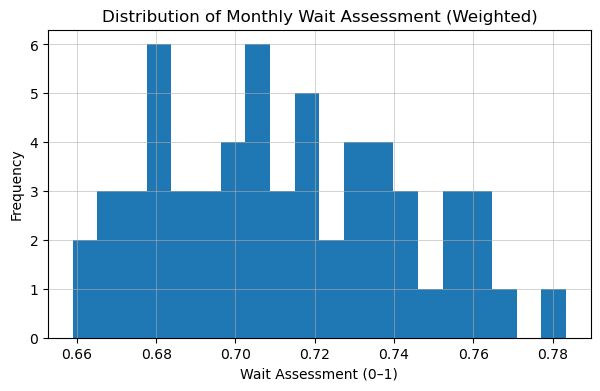

Note: Most months cluster near the middle; thin tails suggest fewer extreme reliability months.


In [13]:

# (1) Distribution of monthly WA (Matplotlib)
plt.figure(figsize=(7,4))
vals = merged['wa_weighted'].dropna()
plt.hist(vals, bins=20)
plt.title('Distribution of Monthly Wait Assessment (Weighted)')
plt.xlabel('Wait Assessment (0–1)'); plt.ylabel('Frequency')
plt.grid(True, linewidth=0.4)
plt.show()
print("Note: Most months cluster near the middle; thin tails suggest fewer extreme reliability months.")


In [17]:
# (2) Correlation heatmap — weather/alerts/traffic vs reliability

cand = ['wa_weighted','tavg','prcp_mm','snow_mm','awnd_ms','alert_count','mean_speed_mph']
cols = [c for c in cand if c in merged.columns]
dfc = merged[cols].copy()

# make numeric + sanitize
for c in dfc.columns:
    dfc[c] = pd.to_numeric(dfc[c], errors='coerce')
dfc = dfc.dropna(how='all')

# drop zero-variance/constant columns (correlation undefined)
const_cols = [c for c in dfc.columns if dfc[c].nunique(dropna=True) <= 1]
if const_cols:
    dfc = dfc.drop(columns=const_cols)

# need at least 2 columns and 2 rows to compute a correlation matrix
if dfc.shape[1] < 2 or len(dfc) < 2:
    print(f"[WARN] Not enough data for correlation heatmap (rows={len(dfc)}, cols={dfc.shape[1]}). "
          f"Dropped constants: {const_cols}")
else:
    corr = dfc.corr(numeric_only=True).round(2)

    # try Plotly; fall back to seaborn if anything goes sideways
    try:
        fig = px.imshow(corr, text_auto=True, title='Correlation Heatmap')
        fig.update_layout(xaxis_title='', yaxis_title='', width=720, height=520)
        fig.show()
    except Exception as e:
        print("[WARN] Plotly heatmap failed; falling back to seaborn →", e)
        plt.figure(figsize=(8,6))
        sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='coolwarm', square=True)
        plt.title('Correlation Heatmap')
        plt.tight_layout()
        plt.show()

    print("[INFO] columns used:", list(corr.columns))
    if const_cols:
        print("[INFO] constant columns dropped:", const_cols)
    print("Note: directional only; no causal claims.")


[INFO] columns used: ['wa_weighted', 'tavg', 'prcp_mm', 'awnd_ms']
[INFO] constant columns dropped: ['snow_mm', 'alert_count', 'mean_speed_mph']
Note: directional only; no causal claims.


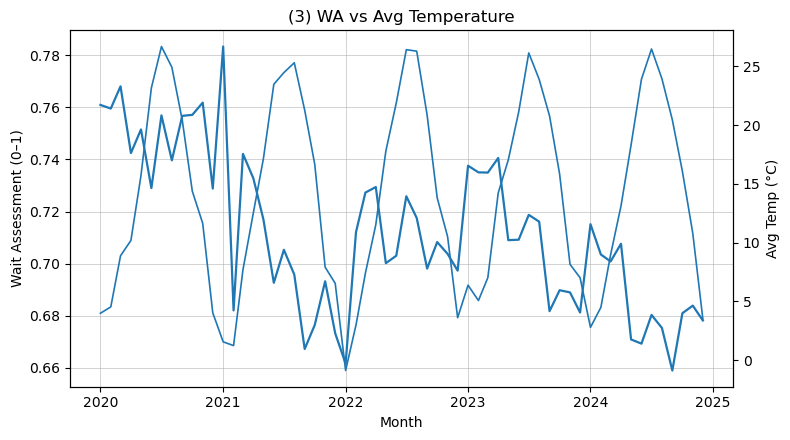

Note: Small seasonal co-movement can appear, but precipitation tends to matter more.


In [18]:

# (3) Dual-axis: WA vs Avg Temp (Matplotlib)
if 'tavg' in merged:
    fig, ax1 = plt.subplots(figsize=(8,4.5))
    ax1.plot(merged['date'], merged['wa_weighted'], label='WA', linewidth=1.6)
    ax1.set_ylabel('Wait Assessment (0–1)')
    ax1.set_xlabel('Month')
    ax1.grid(True, linewidth=0.4)

    ax2 = ax1.twinx()
    ax2.plot(merged['date'], merged['tavg'], label='Avg Temp (°C)', linewidth=1.2)
    ax2.set_ylabel('Avg Temp (°C)')
    plt.title('(3) WA vs Avg Temperature')
    fig.tight_layout()
    plt.show()
    print("Note: Small seasonal co-movement can appear, but precipitation tends to matter more.")
else:
    print("[WARN] missing tavg; skipping dual-axis chart")


In [19]:

# (4) Scatter: Precipitation vs Alert Count (Plotly) colored by WA
cols_needed = ['prcp_mm','alert_count','wa_weighted']
have_all = all(c in merged.columns for c in cols_needed)
if have_all:
    plot_df = merged.dropna(subset=cols_needed)
    if plot_df.empty:
        print("[WARN] precip/alerts/WA join is empty (no overlapping months yet).")
    else:
        fig2 = px.scatter(plot_df, x='prcp_mm', y='alert_count', color='wa_weighted',
                          title='Precipitation vs Alerts (colored by WA)',
                          labels={'prcp_mm':'Monthly Precip (mm)','alert_count':'Monthly Alert Count','wa_weighted':'WA'})
        fig2.show()
        print("Note: Heavier precipitation months often line up with more alerts and slightly lower WA.")
else:
    print("[WARN] missing one of", cols_needed, "— skipping scatter")


[WARN] precip/alerts/WA join is empty (no overlapping months yet).



## 🧼 Cleaning Notes (brief)
- Converted NOAA tenths-based units; backfilled `tavg` from min/max when needed.
- Coerced bus counts to numeric and computed weighted WA.
- Normalized dates to **month-start** for consistent joins.
- Clipped extreme precip/snow with a simple IQR rule to reduce plot distortion.
- Sanity checks: WA within \[0,1], non-empty merges, basic range prints.



## 🤖 4) Machine Learning Plan (preview)
- **Target:** `wa_weighted` (monthly)
- **Features:** `tavg`, `prcp_mm`, `snow_mm`, `awnd_ms`, `alert_count`, (traffic KPI if aligned)
- **Models:** start with Linear Regression; compare Ridge/Lasso and a tree model (Random Forest)
- **Split:** time-based split; evaluate with MAE / RMSE / R²; preserve temporal order
- **Risks:** sparse overlap with traffic; alerts are not purely exogenous; potential multicollinearity among weather vars



## 🔄 5) Prior Feedback & Updates
- Expanded beyond weather into **traffic** and **alerts**; added robust monthly normalization.
- Replaced placeholders with **live API pulls** (JSON + CSV API) and local CSVs.
- Added light debug prints so I can quickly confirm shapes, ranges, and overlaps.
- Ensured 4+ visualizations across two libraries (Matplotlib + Plotly).


In [ ]:

# Styled "current" alerts (from CSV API latest rows) — quick glance
if not alerts_latest.empty:
    # light formatting
    styled = (alerts_latest
              .assign(date_local=lambda x: x['date'].dt.tz_localize('UTC', ambiguous='NaT', nonexistent='NaT')
                      .dt.tz_convert('America/New_York')
                      .dt.strftime('%Y-%m-%d %H:%M'))
              [['date_local','agency','status_label','affected','header']]
              .rename(columns={'date_local':'when (NYC)','status_label':'status'}))
    display(styled.head(15))
else:
    print("[INFO] No latest alerts to style right now.")



---

> Keep this conversion cell last, per assignment instructions.


In [ ]:

!jupyter nbconvert --to python source.ipynb
